In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

%matplotlib inline

DIR = r'c://downloads'

plt.style.use('ggplot')

In [2]:
# From: ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_29/gencode.v29.annotation.gtf.gz
gene_annotations = pd.read_csv(os.path.join(DIR, 'gencode.v29.annotation.gtf.gz'), sep = '\t', comment = '#', \
        names = ['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'extra_fields'])
        
def parse_extra_fields(raw_extra_fields):

    extra_fields = {}

    for raw_extra_field in raw_extra_fields[:-1].split(';'):
        key, raw_value = raw_extra_field.strip().split(' ')
        value = raw_value.strip('"')
        extra_fields[key] = value
        
    return extra_fields
        
gene_annotations['extra_fields'] = gene_annotations['extra_fields'].apply(parse_extra_fields)
gene_annotations['gene_id'] = gene_annotations['extra_fields'].apply(lambda extra_fields: extra_fields['gene_id'].split('.')[0])

transcript_annotations = gene_annotations[gene_annotations['type'] == 'transcript']
transcript_chromosomes = transcript_annotations[['gene_id', 'chr', 'strand']].drop_duplicates().reset_index()

display(transcript_chromosomes)

,index,gene_id,chr,strand
0,1,ENSG00000223972,chr1,+
1,13,ENSG00000227232,chr1,-
2,26,ENSG00000278267,chr1,-
3,29,ENSG00000243485,chr1,+
4,37,ENSG00000284332,chr1,+
5,40,ENSG00000237613,chr1,-
6,48,ENSG00000268020,chr1,+
7,51,ENSG00000240361,chr1,+
8,58,ENSG00000186092,chr1,+
9,77,ENSG00000238009,chr1,-


In [3]:
chromosome_and_strand_counts = transcript_chromosomes.groupby(['chr', 'strand']).size().rename('count').reset_index()
display(chromosome_and_strand_counts.head())

,chr,strand,count
0,chr1,+,2687
1,chr1,-,2630
2,chr10,+,1158
3,chr10,-,1082
4,chr11,+,1655


In [4]:
pos_counts = chromosome_and_strand_counts[chromosome_and_strand_counts['strand'] == '+'].set_index('chr')['count']
neg_counts = chromosome_and_strand_counts[chromosome_and_strand_counts['strand'] == '-'].set_index('chr')['count']
counts_diff = (pos_counts - neg_counts).abs() / (pos_counts + neg_counts)
print(counts_diff.sort_values(ascending = False))

chr
chrM     0.513514
chr22    0.098300
chr7     0.065478
chr8     0.039396
chr10    0.033929
chr14    0.029596
chr16    0.029049
chr19    0.022643
chrX     0.022316
chr17    0.021825
chr18    0.021133
chr21    0.020408
chr15    0.015145
chr20    0.013601
chr4     0.013546
chrY     0.012433
chr9     0.010989
chr1     0.010720
chr2     0.009985
chr11    0.007610
chr6     0.006536
chr12    0.005726
chr3     0.003279
chr5     0.001390
chr13    0.000749
Name: count, dtype: float64


In [5]:
refseqs = []
tissues = []

# From: http://bioinfo.wilmer.jhu.edu/tiger/download/ref2tissue-Table.txt
with open(os.path.join(DIR, 'ref2tissue-Table.txt'), 'r') as f:
    
    f.readline()
    
    for line in f:
        
        line_parts = line.strip().split('\t')
        refseq = line_parts[0]
        
        for tissue in line_parts[1:]:
            refseqs.append(refseq)
            tissues.append(tissue)
        
tissue_expression = pd.DataFrame({'refseq': refseqs, 'tissue': tissues})
display(tissue_expression.head())

,refseq,tissue
0,NM_033169,bladder
1,NM_000253,liver
2,NM_000253,small_intestine
3,NM_033168,bladder
4,NM_000252,liver


In [6]:
import json

# From: ftp://ftp.ebi.ac.uk/pub/databases/genenames/new/json/non_alt_loci_set.json
with open(os.path.join(DIR, 'non_alt_loci_set.json'), 'r', encoding = 'utf-8') as f:
    gene_names = json.load(f)
    
symbols = []
names = []
ensembel_ids = []
refseqs = []
uniprot_ids = []
gene_groups = []

for record in gene_names['response']['docs']:
    for refseq in record.get('refseq_accession', [np.nan]):
        symbols.append(record['symbol'])
        names.append(record['name'])
        ensembel_ids.append(record.get('ensembl_gene_id', np.nan))
        refseqs.append(refseq)
        uniprot_ids.append(record.get('uniprot_ids', []))
        gene_groups.append(record.get('gene_group', []))
        
gene_meta_data = pd.DataFrame({'symbol': symbols, 'name': names, 'ensembel_id': ensembel_ids, 'refseq': refseqs, \
        'uniprot_ids': uniprot_ids, 'gene_groups': gene_groups})
        
display(gene_meta_data.head())

,symbol,name,ensembel_id,refseq,uniprot_ids,gene_groups
0,A1BG,alpha-1-B glycoprotein,ENSG00000121410,NM_130786,[P04217],[Immunoglobulin like domain containing]
1,A1BG-AS1,A1BG antisense RNA 1,ENSG00000268895,NR_015380,[],[Antisense RNAs]
2,A1CF,APOBEC1 complementation factor,ENSG00000148584,NM_014576,[Q9NQ94],[RNA binding motif containing]
3,A2M,alpha-2-macroglobulin,ENSG00000175899,NM_000014,[P01023],"[C3 and PZP like, alpha-2-macroglobulin domain..."
4,A2M-AS1,A2M antisense RNA 1,ENSG00000245105,NR_026971,[],[Antisense RNAs]


In [7]:
gene_tissue_annotations = pd.merge(gene_meta_data, tissue_expression, on = 'refseq')
gene_tissue_annotations = pd.merge(gene_tissue_annotations, transcript_chromosomes, left_on = 'ensembel_id', \
        right_on = 'gene_id').drop(columns = ['gene_id'])
display(gene_tissue_annotations)

,symbol,name,ensembel_id,refseq,uniprot_ids,gene_groups,tissue,index,chr,strand
0,A1BG,alpha-1-B glycoprotein,ENSG00000121410,NM_130786,[P04217],[Immunoglobulin like domain containing],liver,2491117,chr19,-
1,A1CF,APOBEC1 complementation factor,ENSG00000148584,NM_014576,[Q9NQ94],[RNA binding motif containing],liver,1339593,chr10,-
2,A1CF,APOBEC1 complementation factor,ENSG00000148584,NM_014576,[Q9NQ94],[RNA binding motif containing],stomach,1339593,chr10,-
3,A2M,alpha-2-macroglobulin,ENSG00000175899,NM_000014,[P01023],"[C3 and PZP like, alpha-2-macroglobulin domain...",liver,1596480,chr12,-
4,A2ML1,alpha-2-macroglobulin like 1,ENSG00000166535,NM_144670,[A8K2U0],"[C3 and PZP like, alpha-2-macroglobulin domain...",colon,1595751,chr12,+
5,A2ML1,alpha-2-macroglobulin like 1,ENSG00000166535,NM_144670,[A8K2U0],"[C3 and PZP like, alpha-2-macroglobulin domain...",tongue,1595751,chr12,+
6,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",ENSG00000128274,NM_017436,[Q9NPC4],"[Alpha 1,4-glycosyltransferases, Blood group a...",spleen,2632784,chr22,-
7,AADAC,arylacetamide deacetylase,ENSG00000114771,NM_001086,[P22760],"[Lipases, Arylacetamide deacetylase family]",liver,587516,chr3,+
8,AADACL2,arylacetamide deacetylase like 2,ENSG00000197953,NM_207365,[Q6P093],[Arylacetamide deacetylase family],uterus,587440,chr3,+
9,AASS,aminoadipate-semialdehyde synthase,ENSG00000008311,NM_005763,[Q9UDR5],[],larynx,1078540,chr7,-


Text(0.5,1,'Tissue-Chromosome Enrichment of Genes')

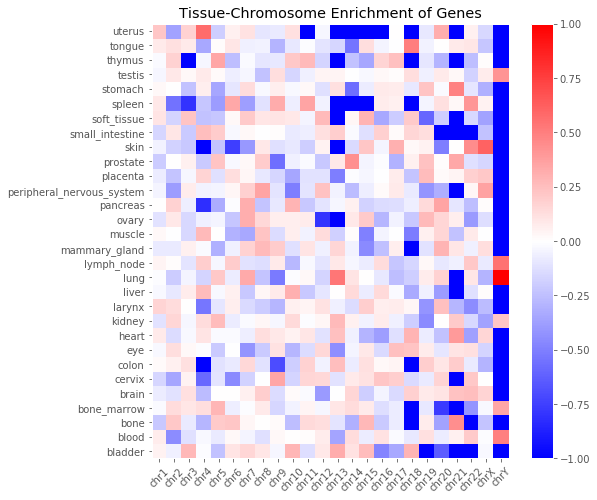

In [8]:
tissues = list(sorted(gene_tissue_annotations['tissue'].unique()))
chromosomes = ['chr%s' % chr_id for chr_id in (list(map(str, range(1, 23))) + ['X', 'Y'])]
n_tissues = len(tissues)
n_chromosomes = len(chromosomes)

def calc_tissue_chromosome_enrichment(tissue, chromosome):
    
    tissue_mask = (gene_tissue_annotations['tissue'] == tissue)
    chromosome_mask = (gene_tissue_annotations['chr'] == chromosome)
    n_observed = (tissue_mask & chromosome_mask).sum()
    # The expected number is Ni * Nj / N, where N is the total size of the dataset.
    # This is because we have that (Ni / N) fraction of the records belong to category i and (Nj / N) belong to
    # category j, so if the two categories were independent, we would expect (Ni / N) * (Nj / N) fraction of the
    # records to belong to both, meaning that out of a total of N records, we would expect N * (Ni / N) * (Nj / N)
    # records.
    n_expected = tissue_mask.sum() * chromosome_mask.sum() / len(gene_tissue_annotations)
    
    # Since we cannot calculate the log of 0, we trim all the values at -1. 
    if n_observed == 0:
        return -1
    else:
        return np.max(np.log10(n_observed / n_expected), -1)
    
associations = np.empty((n_tissues, n_chromosomes))

for i, tissue in enumerate(tissues):
    for j, chromosome in enumerate(chromosomes):
        associations[i, j] = calc_tissue_chromosome_enrichment(tissue, chromosome)
        
fig, ax = plt.subplots(figsize = (8, 8))
heatmap = ax.pcolor(associations, cmap = 'bwr', vmin = -1, vmax = 1)
fig.colorbar(heatmap)

ax.set_xlim((0, n_chromosomes))
ax.set_xticks(np.arange(n_chromosomes) + 0.5)
ax.set_xticklabels(chromosomes, rotation = 45)
ax.set_ylim((0, n_tissues))
ax.set_yticks(np.arange(n_tissues) + 0.5)
ax.set_yticklabels(tissues)

ax.set_title('Tissue-Chromosome Enrichment of Genes')

chrX seems enriched for genes expressed in skin tissues, as well as those expressed in the brain and the peripheral nervous system (and also, to a lower extent, the placenta, heart, mammary gland and testis).

This analysis is rather superficial though. As it doesn't include statistical tests, we cannot say whether these enrichments could be explained by randomness.